In [ ]:
import pandas as pd

df = pd.read_csv(r"synthetic_cancer_treatment_dataset.csv")

df.head()


,age,cancer_stage,targetable_mutation,comorbidity_score,treatment_type,treatment_response
0,68,4,1,0.73,chemo,0
1,68,4,1,0.73,targeted,0
2,68,4,1,0.73,immuno,0
3,40,3,1,0.60,chemo,0
4,40,3,1,0.60,targeted,1


In [2]:
df.shape


(1200, 6)

In [3]:
df.isnull().sum()

age                    0
cancer_stage           0
targetable_mutation    0
comorbidity_score      0
treatment_type         0
treatment_response     0
dtype: int64

In [4]:
df["treatment_response"].value_counts(normalize=True)


treatment_response
0    0.735833
1    0.264167
Name: proportion, dtype: float64

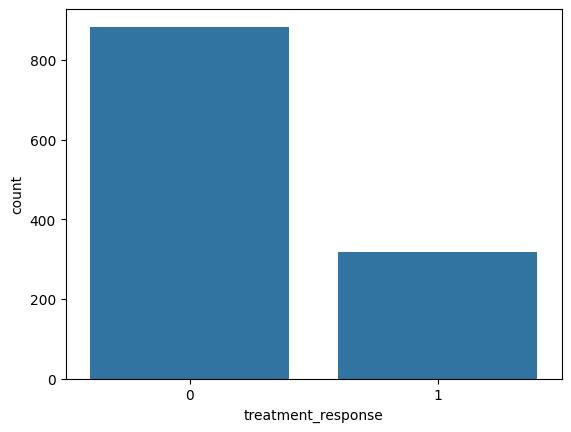

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="treatment_response", data=df)
plt.show()


In [6]:
df[["age","cancer_stage","comorbidity_score"]].describe()

,age,cancer_stage,comorbidity_score
count,1200.000000,1200.000000,1200.000000
mean,55.310000,2.547500,0.514900
std,15.087365,1.121959,0.290269
min,30.000000,1.000000,0.000000
25%,42.750000,1.000000,0.270000
50%,56.000000,3.000000,0.525000
75%,69.000000,3.000000,0.762500
max,80.000000,4.000000,1.000000


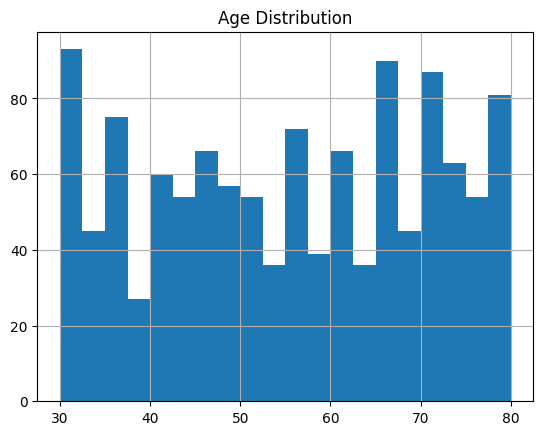

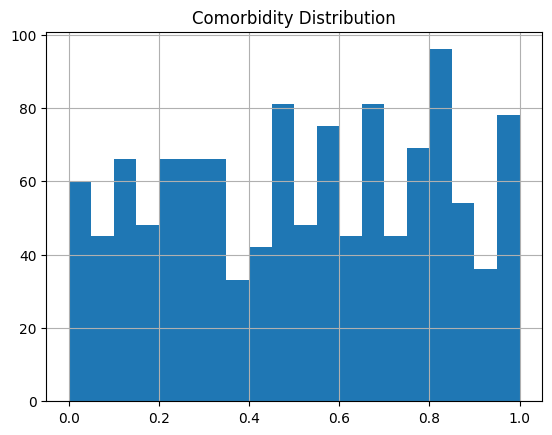

In [7]:
df["age"].hist(bins=20)
plt.title("Age Distribution")
plt.show()

df["comorbidity_score"].hist(bins=20)
plt.title("Comorbidity Distribution")
plt.show()


In [8]:
df.groupby("cancer_stage")["treatment_response"].mean()


cancer_stage
1    0.398058
2    0.333333
3    0.196237
4    0.158249
Name: treatment_response, dtype: float64

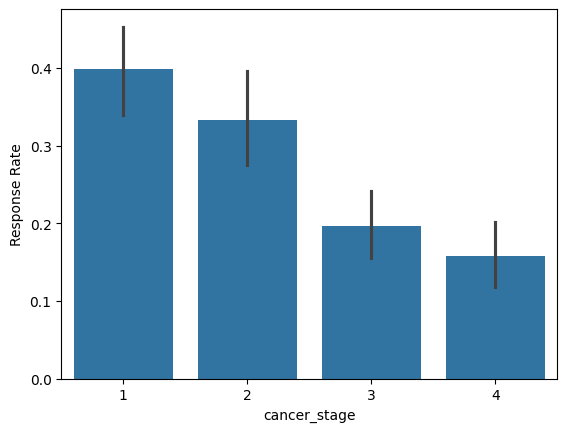

In [9]:
sns.barplot(x="cancer_stage", y="treatment_response", data=df)
plt.ylabel("Response Rate")
plt.show()


In [10]:
df.groupby("targetable_mutation")["treatment_response"].mean()


targetable_mutation
0    0.210826
1    0.339357
Name: treatment_response, dtype: float64

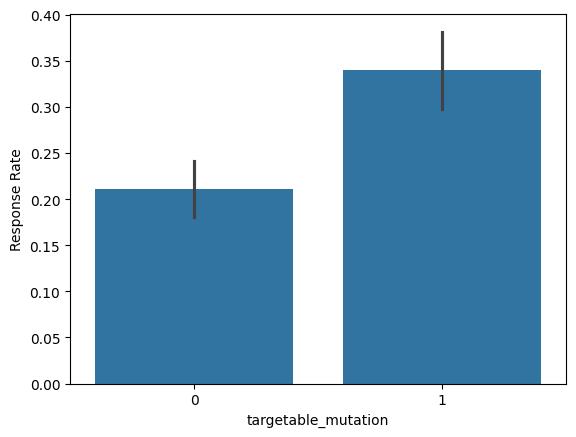

In [11]:
sns.barplot(x="targetable_mutation", y="treatment_response", data=df)
plt.ylabel("Response Rate")
plt.show()


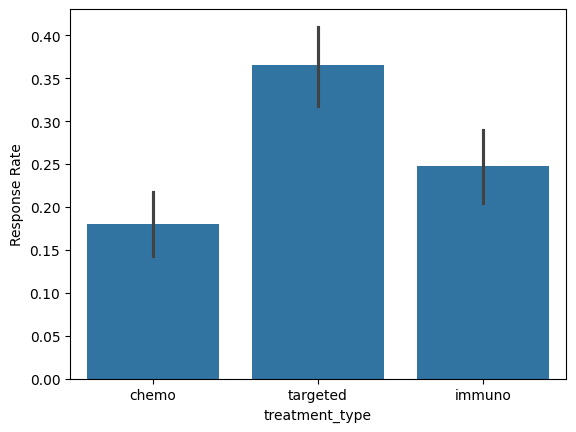

In [12]:
df.groupby("treatment_type")["treatment_response"].mean()
sns.barplot(x="treatment_type", y="treatment_response", data=df)
plt.ylabel("Response Rate")
plt.show()


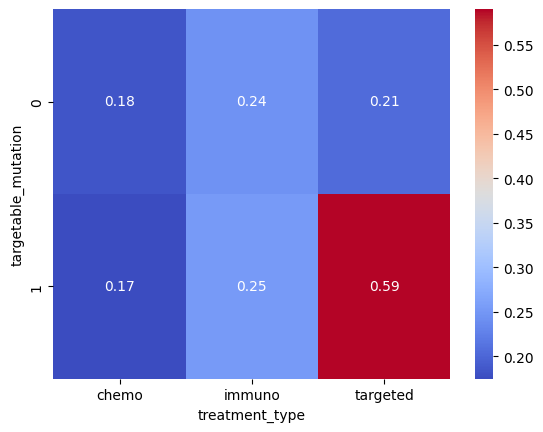

In [13]:
df.groupby(
    ["targetable_mutation", "treatment_type"]
)["treatment_response"].mean()
pivot = df.pivot_table(
    values="treatment_response",
    index="targetable_mutation",
    columns="treatment_type",
    aggfunc="mean"
)

sns.heatmap(pivot, annot=True, cmap="coolwarm")
plt.show()


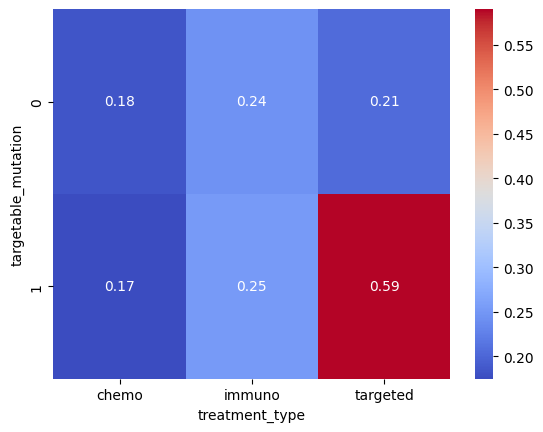

In [14]:
df.groupby(
    ["targetable_mutation", "treatment_type"]
)["treatment_response"].mean()
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df.pivot_table(
    values="treatment_response",
    index="targetable_mutation",
    columns="treatment_type",
    aggfunc="mean"
)

sns.heatmap(pivot, annot=True, cmap="coolwarm")
plt.show()



=== BASELINE ROC-AUC ===
0.7095327773293875

=== THRESHOLD TUNING ===

--- Threshold = 0.3 ---
              precision    recall  f1-score   support

           0       0.86      0.59      0.70       177
           1       0.39      0.73      0.51        63

    accuracy                           0.62       240
   macro avg       0.62      0.66      0.60       240
weighted avg       0.74      0.62      0.65       240


--- Threshold = 0.4 ---
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       177
           1       0.41      0.51      0.45        63

    accuracy                           0.68       240
   macro avg       0.61      0.62      0.61       240
weighted avg       0.70      0.68      0.69       240


--- Threshold = 0.5 ---
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       177
           1       0.48      0.32      0.38        63

    accuracy                        

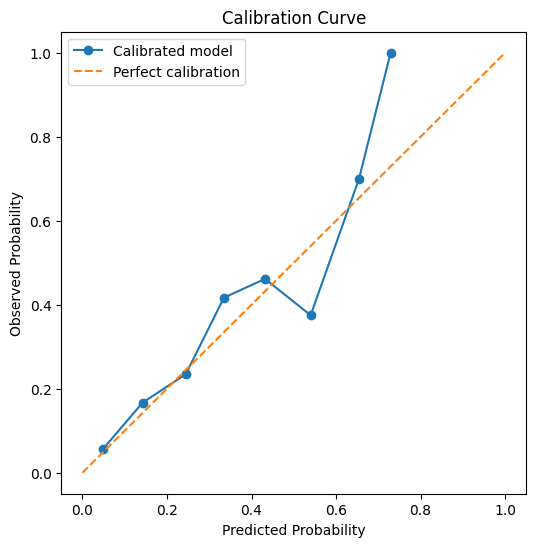


=== FINAL MODEL EVALUATION (CALIBRATED + THRESHOLD) ===
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       177
           1       0.55      0.29      0.38        63

    accuracy                           0.75       240
   macro avg       0.66      0.60      0.61       240
weighted avg       0.72      0.75      0.72       240


=== CLINICAL SANITY CHECK ===
Predicted response probability (targeted): 0.487

Calibrated model saved as model_calibrated.pkl


In [23]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# =========================
# 1. LOAD DATA + MODEL
# =========================



df = pd.read_csv(r"C:\Users\hp\Downloads\synthetic_cancer_treatment_dataset.csv")




X = df.drop(columns=["treatment_response"])
y = df["treatment_response"]

pipeline = joblib.load("model.pkl")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =========================
# 2. BASELINE PROBABILITIES
# =========================

y_prob_uncal = pipeline.predict_proba(X_test)[:, 1]

print("\n=== BASELINE ROC-AUC ===")
print(roc_auc_score(y_test, y_prob_uncal))

# =========================
# 3. THRESHOLD TUNING
# =========================

print("\n=== THRESHOLD TUNING ===")

def evaluate_threshold(threshold):
    y_pred = (y_prob_uncal >= threshold).astype(int)
    print(f"\n--- Threshold = {threshold} ---")
    print(classification_report(y_test, y_pred))

for t in [0.3, 0.4, 0.5]:
    evaluate_threshold(t)

FINAL_THRESHOLD = 0.4
print(f"\nSelected threshold = {FINAL_THRESHOLD}")

# =========================
# 4. PROBABILITY CALIBRATION
# =========================

print("\n=== PROBABILITY CALIBRATION ===")

calibrated_model = CalibratedClassifierCV(
    estimator=pipeline,
    method="isotonic",
    cv=3
)

calibrated_model.fit(X_train, y_train)

y_prob_cal = calibrated_model.predict_proba(X_test)[:, 1]

print("Uncalibrated AUC:", roc_auc_score(y_test, y_prob_uncal))
print("Calibrated AUC  :", roc_auc_score(y_test, y_prob_cal))

# =========================
# 5. CALIBRATION CURVE
# =========================

prob_true, prob_pred = calibration_curve(
    y_test, y_prob_cal, n_bins=10
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Calibrated model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()

# =========================
# 6. FINAL EVALUATION
# =========================

print("\n=== FINAL MODEL EVALUATION (CALIBRATED + THRESHOLD) ===")

y_final_pred = (y_prob_cal >= FINAL_THRESHOLD).astype(int)

print(classification_report(y_test, y_final_pred))

# =========================
# 7. CLINICAL SANITY CHECK
# =========================

print("\n=== CLINICAL SANITY CHECK ===")

test_patient = pd.DataFrame([{
    "age": 55,
    "cancer_stage": 3,
    "targetable_mutation": 1,
    "comorbidity_score": 0.3,
    "treatment_type": "targeted"
}])

prob = calibrated_model.predict_proba(test_patient)[0][1]
print("Predicted response probability (targeted):", round(prob, 3))

# =========================
# 8. SAVE CALIBRATED MODEL
# =========================

joblib.dump(calibrated_model, "model_calibrated.pkl")
print("\nCalibrated model saved as model_calibrated.pkl")


In [32]:
import joblib
import pandas as pd

CALIBRATION_THRESHOLD = 0.4

calibrated_model = joblib.load("model_calibrated.pkl")


In [33]:
def predict_single_calibrated(
    age: int,
    cancer_stage: int,
    targetable_mutation: int,
    comorbidity_score: float,
    treatment_type: str
):
    input_df = pd.DataFrame([{
        "age": age,
        "cancer_stage": cancer_stage,
        "targetable_mutation": targetable_mutation,
        "comorbidity_score": comorbidity_score,
        "treatment_type": treatment_type
    }])

    prob = calibrated_model.predict_proba(input_df)[0][1]
    pred_class = int(prob >= CALIBRATION_THRESHOLD)

    return {
        "response_probability": round(prob, 3),
        "predicted_class": pred_class,
        "threshold": CALIBRATION_THRESHOLD
    }


In [34]:
print(
    predict_single_calibrated(
        age=55,
        cancer_stage=3,
        targetable_mutation=1,
        comorbidity_score=0.3,
        treatment_type="targeted"
    )
)


{'response_probability': np.float64(0.487), 'predicted_class': 1, 'threshold': 0.4}


In [35]:
import shap

# Pull out pieces from the calibrated estimator
base_pipeline = calibrated_model.estimator
preprocessor = base_pipeline.named_steps["preprocessor"]
rf_model = base_pipeline.named_steps["model"]

explainer = shap.TreeExplainer(rf_model)

In [36]:
def explain_single(input_df: pd.DataFrame, top_k=5):
    # Transform input
    X_trans = preprocessor.transform(input_df)

    shap_values = explainer.shap_values(X_trans)

    # --- Normalize SHAP output ---
    if isinstance(shap_values, list):
        # Old-style: [class0, class1]
        shap_vals = shap_values[1][0]   # shape: (n_features,)
    else:
        # New-style: array
        shap_vals = shap_values[0]

        # If still 2D (n_features, n_classes), select positive class
        if shap_vals.ndim == 2:
            shap_vals = shap_vals[:, 1]

    feature_names = preprocessor.get_feature_names_out()

    contrib = pd.Series(shap_vals, index=feature_names)

    return {
        "top_positive_contributors": contrib.sort_values(ascending=False)
                                            .head(top_k)
                                            .round(3)
                                            .to_dict(),
        "top_negative_contributors": contrib.sort_values()
                                            .head(top_k)
                                            .round(3)
                                            .to_dict()
    }


In [37]:
def predict_with_explanation(
    age, cancer_stage, targetable_mutation, comorbidity_score, treatment_type
):
    input_df = pd.DataFrame([{
        "age": age,
        "cancer_stage": cancer_stage,
        "targetable_mutation": targetable_mutation,
        "comorbidity_score": comorbidity_score,
        "treatment_type": treatment_type
    }])

    prob = calibrated_model.predict_proba(input_df)[0][1]
    pred_class = int(prob >= CALIBRATION_THRESHOLD)

    explanation = explain_single(input_df)

    return {
        "response_probability": round(prob, 3),
        "predicted_class": pred_class,
        "threshold": CALIBRATION_THRESHOLD,
        "explanation": explanation
    }


In [38]:
out = predict_with_explanation(
    age=55,
    cancer_stage=3,
    targetable_mutation=1,
    comorbidity_score=0.3,
    treatment_type="targeted"
)

print(out)


{'response_probability': np.float64(0.487), 'predicted_class': 1, 'threshold': 0.4, 'explanation': {'top_positive_contributors': {'num__targetable_mutation': 0.125, 'cat__treatment_type_targeted': 0.09, 'cat__treatment_type_chemo': 0.039, 'cat__treatment_type_immuno': 0.011, 'num__age': -0.006}, 'top_negative_contributors': {'num__cancer_stage': -0.096, 'num__comorbidity_score': -0.052, 'num__age': -0.006, 'cat__treatment_type_immuno': 0.011, 'cat__treatment_type_chemo': 0.039}}}


def compare_treatments(
    age, cancer_stage, targetable_mutation, comorbidity_score,
    treatments=("chemo", "targeted", "immuno")
):
    results = []
    for t in treatments:
        res = predict_with_explanation(
            age, cancer_stage, targetable_mutation, comorbidity_score, t
        )
        res["treatment_type"] = t
        results.append(res)
    return results


In [40]:
def compare_treatments(
    age,
    cancer_stage,
    targetable_mutation,
    comorbidity_score,
    treatments=("chemo", "targeted", "immuno")
):
    results = []

    for t in treatments:
        res = predict_with_explanation(
            age=age,
            cancer_stage=cancer_stage,
            targetable_mutation=targetable_mutation,
            comorbidity_score=comorbidity_score,
            treatment_type=t
        )
        res["treatment_type"] = t
        results.append(res)

    return results


In [41]:
comparison = compare_treatments(
    age=55,
    cancer_stage=3,
    targetable_mutation=1,
    comorbidity_score=0.3
)
for r in comparison:
    print(r["treatment_type"], r["response_probability"])


chemo 0.115
targeted 0.487
immuno 0.342


In [42]:
import shap

def _get_shap_explanation(self, input_df, top_k=4):
    X_trans = self.preprocessor.transform(input_df)

    explainer = shap.TreeExplainer(self.rf_model)
    shap_values = explainer.shap_values(X_trans)

    # Normalize SHAP output
    if isinstance(shap_values, list):
        shap_vals = shap_values[1][0]
    else:
        shap_vals = shap_values[0]
        if shap_vals.ndim == 2:
            shap_vals = shap_vals[:, 1]

    feature_names = self.preprocessor.get_feature_names_out()
    contrib = pd.Series(shap_vals, index=feature_names)

    positive = contrib.sort_values(ascending=False).head(top_k)
    negative = contrib.sort_values().head(top_k)

    return {
        "positive_factors": positive.round(3).to_dict(),
        "negative_factors": negative.round(3).to_dict()
    }


In [43]:
{
  "positive_factors": {
    "num__targetable_mutation": 0.182,
    "cat__treatment_type_targeted": 0.146
  },
  "negative_factors": {
    "num__cancer_stage": -0.121,
    "num__comorbidity_score": -0.084
  }
}


{'positive_factors': {'num__targetable_mutation': 0.182,
  'cat__treatment_type_targeted': 0.146},
 'negative_factors': {'num__cancer_stage': -0.121,
  'num__comorbidity_score': -0.084}}

In [46]:
def _predict_for_treatment(self, patient_data, treatment):
    input_df = self._build_input_df(patient_data, treatment)

    prob = float(self.model.predict_proba(input_df)[0][1])

    shap_data = self._get_shap_explanation(input_df)

    llm_text = self._generate_llm_explanation(
        patient_data=patient_data,
        treatment=treatment,
        prob=round(prob, 3),
        shap_data=shap_data
    )

    return {
        "treatment": treatment,
        "response_probability": round(prob, 3),
        "predicted_response": int(prob >= CALIBRATION_THRESHOLD),
        "shap_explanation": shap_data,
        "llm_explanation": llm_text
    }


In [ ]:
def _generate_llm_explanation(self, patient_data, treatment, prob, shap_data):
    prompt = PromptTemplate(
        input_variables=[
            "age", "stage", "treatment", "prob",
            "positive", "negative"
        ],
        template="""
You are an AI-powered clinical decision-support assistant for oncology.
Your role is to EXPLAIN model predictions, not to make medical decisions.

Context:
This system supports oncologists in personalized cancer treatment planning
by analyzing patient-specific clinical and genomic factors and presenting
transparent, evidence-grounded reasoning for predicted outcomes.

Patient profile:
- Age: {age}
- Cancer stage: {stage}

Treatment option evaluated:
- Treatment modality: {treatment}
- Predicted likelihood of favorable response: {prob}

Model-grounded reasoning (source: feature-attribution analysis):
The following factors were identified by the AI model as influential.
You MUST rely ONLY on these factors.

Factors increasing likelihood of response:
{positive}

Factors decreasing likelihood of response:
{negative}

Instructions for explanation:
- Clearly explain WHY this treatment has the predicted response likelihood
- Use simple, clinician-friendly medical language
- Explicitly reference the positive and negative factors above
- Describe how these factors interact to influence expected outcome
- Emphasize uncertainty and variability in patient response
- Do NOT recommend or reject this treatment
- Do NOT compare treatments unless explicitly stated
- Do NOT provide medical advice or prescriptions
- Do NOT introduce any new clinical factors or assumptions

Output style requirements:
- 1 short paragraph (5–7 sentences)
- Neutral, factual, and supportive tone
- Suitable for display in a clinical dashboard
- Intended to support shared decision-making between doctor and patient
"""
    )

    return self.llm(
        prompt.format(
            age=patient_data["age"],
            stage=patient_data["stage"],
            treatment=treatment,
            prob=prob,
            positive=shap_data["positive_factors"],
            negative=shap_data["negative_factors"]
        )
    )
